# __Nice Riding with Python - Visualizing Riding & Weather Patterns in the Twin Cities__
### I developed this Jupyter notebook visualizing bike riding & weather patterns in the Twin Cities as part of my final project for my Programming for Data Science course. I developed my initial draft, which included over a dozen visualizations and two hundred lines of code, in three days in early December 2018; it has undergone many, many improvements and iterations since.
### Minneapolis has been consistently recognized as one of the bike friendliest cities in the continental U.S, and as recently as 2015 was named the #1 bike friendly city in America.
### One of the biggest factors in the increase of bike ridership is the bike-sharing nonprofit company Nice Ride MN (serving both Minneapolis and St. Paul) that was introduced in 2010. Customers rent bikes at stations that are distributed throughout the Twin Cities. Customers then bike to their preferred location and return their bike at any other station with an empty dock.
### As an avid biker during the spring/summer/fall months, I noticed that my own riding patterns dropped off once the days grew shorter and the temperatures began dropping below freezing.  I decided to look at if and how ridership in the Twin Cities is affected by the weather patterns and changes throughout the year.

### The first step in any analysis with Python is to pull in the libraries that will be using to perform the myriad of activities required to wrangle, munge, manipulate & analyze the data to get it to look how we want.
- **pandas** is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language (*Excel for Python*).
- **numpy** is the fundamental package for scientific computing with Python (*Perform  linear algebraic functions, random number generation & create multi-dimensional structures*).
- **matplotlib** is a Python 2D plotting library which produces publication quality figures in a variety of formats and interactive environments across platforms (*Make awesome looking graphs and charts*).
- **seaborn** is a Python data visualization library based on matplotlib.  It provides a high-level interface for drawing attractive and informative statistical graphics (*Essentially matplotlib 2.0*).
- **folium** is a Python library that makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for visualizations as well as passing HTML visualizations as markers on the map (*Build your own Google Map with Python*).
- **zipfile** is a Python module module that can be used to manipulate ZIP archive files.  (*The trip history data set was too big to host on my Github so I zipped it up to be able to upload it!*)
- **datetime** is a Python module that supplies classes for manipulating dates and times in both simple and complex ways (*Allows you to create different date/time formats required for analysis in pandas*).

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import zipfile
import datetime as dt
from datetime import datetime

# __Analysis 1: Comparing members vs. casual riders__

### Pull in stations and trips data sets using pandas to look at distribution of rides and locations 

In [2]:
trips_zipped = zipfile.ZipFile('Nice_ride_trip_history_2017_season.zip')

In [3]:
stations = pd.read_csv('Nice_Ride_2017_Station_Locations.csv', low_memory = False)
trips = pd.read_csv(trips_zipped.open('Nice_ride_trip_history_2017_season.csv'), low_memory = False)

### Confirm the dataframe layout and how many rows each dataframe contains

In [4]:
print(stations.head(2))
print()
print("There are {} rows in the 2017 Nice Ride Station Locations data set.".format(len(stations)))
print()
print(trips.head(2))
print()
print("There are {} rows in the 2017 Nice Ride Trip History data set".format(len(trips)))
print()

  Number                      Name   Latitude  Longitude  Total docks
0  30000        100 Main Street SE  44.984892 -93.256551           27
1  30001  25th Street & 33rd Ave S  44.957341 -93.223374           15

There are 202 rows in the 2017 Nice Ride Station Locations data set.

        Start date                     Start station Start station number  \
0  11/5/2017 21:45   Hennepin Ave & S Washington Ave                30184   
1  11/5/2017 21:45  Broadway Street N & 4th Street E                30122   

          End date                       End station End station number  \
0  11/5/2017 22:02                        Logan Park              30104   
1  11/5/2017 22:26  Broadway Street N & 4th Street E              30122   

  Account type  Total duration (Seconds)  
0       Member                      1048  
1       Member                      2513  

There are 460718 rows in the 2017 Nice Ride Trip History data set



### We start with a very basic analysis - we just want to see if there is a difference in ridership tendencies between members and casual riders
* The first step is to simply make a copy of the *trips* datafame that we call *account_types*, this is a straightforward step
* We also change the "Start date" to a datetime for resampling the data by month (the first of many times we do this)

In [5]:
account_types = trips
account_types['Start date'] = pd.to_datetime(account_types['Start date'], format = "%m/%d/%Y %H:%M")

### We noticed when looking at the counts for each Account type, there is an additional type listed as "Inconnu"... this is most likely "unknown" so we just make this a "Casual" account type

In [6]:
account_types['Account type'].value_counts()

Member     290070
Casual     170646
Inconnu         2
Name: Account type, dtype: int64

In [7]:
account_types.loc[account_types['Account type']=='Inconnu', 'Account type'] = 'Casual'
account_types['Account type'].value_counts()

Member    290070
Casual    170648
Name: Account type, dtype: int64

### We group by Account type, resample the data so that it is monthly (since a daily view doesn't provide a good picture), and get the count of rides and average ride time.
* We also rename the columns to make them easier to read when displaying them in a graph

In [8]:
members_vs_casuals = account_types.groupby('Account type').resample('M', on = 'Start date').agg({'Start station': 'count', 'Total duration (Seconds)': 'mean'}).reset_index()
members_vs_casuals.rename({'Start station': 'Total Number of Rides', 'Total duration (Seconds)': 'Average Ride Time (s)'}, axis = 'columns', inplace = True)
members_vs_casuals.head(1)

,Account type,Start date,Average Ride Time (s),Total Number of Rides
0,Casual,2017-04-30,3735.461743,10142


### Our first analysis & initial observation!  We compare Total Number of Rides and Average Ride Time for Members and Casual Riders by month
* We find that Members take more rides throughout the course of the year, peaking right at the end of July 2017
* But even more interesting than that, we find that Casual riders take MUCH longer trips.  This tells us that Members are most likely commuting to nearby stations on their way to work, etc.
* This is the first of many uses of the **seaborn** library, that helps visualize the patterns in the data

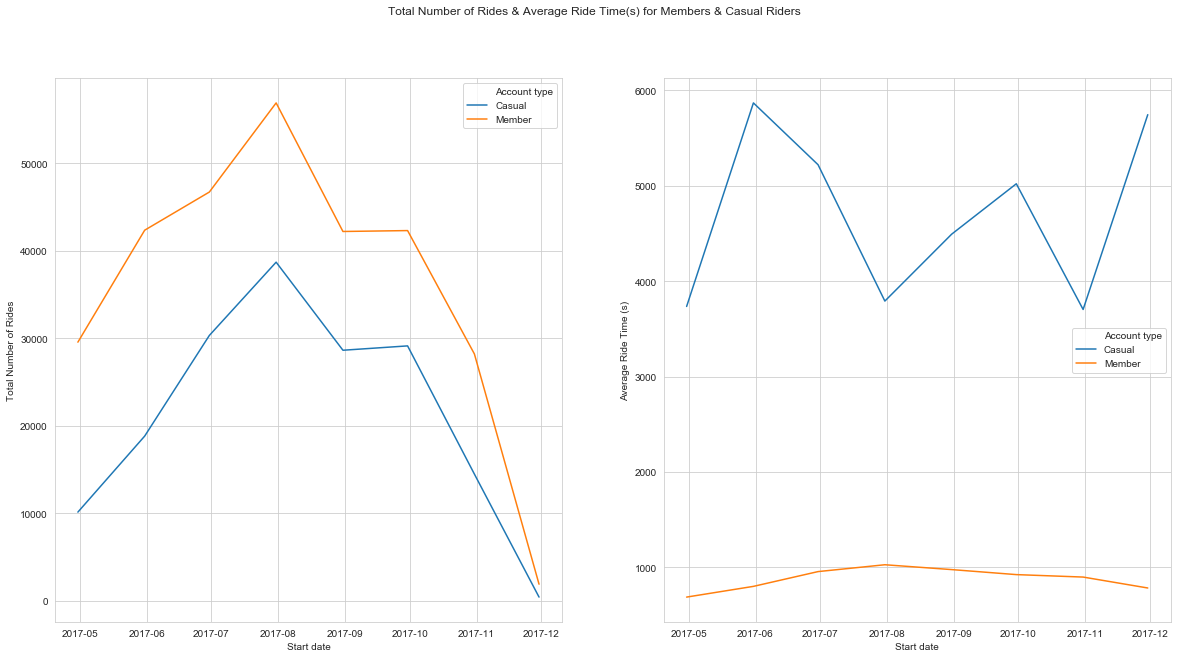

In [9]:
sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.lineplot(x = 'Start date', y = 'Total Number of Rides', hue = 'Account type', data = members_vs_casuals, ax = ax1)

sns.lineplot(x = 'Start date', y = 'Average Ride Time (s)', hue = 'Account type', data = members_vs_casuals, ax = ax2)

plt.suptitle('Total Number of Rides & Average Ride Time(s) for Members & Casual Riders')

plt.show()

# __Analysis 2: Station layout map__

### Begin Station Layout and Analysis
* Create a "Location" column based on the latitudinal and longitudinal coordinates for each station

In [10]:
stations['Location'] = list(zip(stations['Latitude'], stations['Longitude']))
stations.head(1)

,Number,Name,Latitude,Longitude,Total docks,Location
0,30000,100 Main Street SE,44.984892,-93.256551,27,"(44.984891999999995, -93.256551)"


In [11]:
trips.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds)
0,2017-11-05 21:45:00,Hennepin Ave & S Washington Ave,30184,11/5/2017 22:02,Logan Park,30104,Member,1048


### Create initial map of dock stations by location, to get overall view of Nice Ride MN locations
* Notes:
    - **folium** library provides a fantastic way to visualize this data, using the coordinate data from the stations dataset
    - We create a *starting position* variable based on the center most station between the cities (this was after some trial and error)
    - We also create a *average_dock_count* variable and use it to differentiate whether a dock has more/less docks than the average
    - Hover-overs are included and display the dock location and how many docks available

In [12]:
starting_position = list(stations[stations['Name'] == 'Curfew Street & Ellis Ave.'].Latitude) + list(stations[stations['Name'] == 'Curfew Street & Ellis Ave.'].Longitude)

average_dock_count = stations['Total docks'].mean()

In [13]:
initial_folium_map = folium.Map(location=(starting_position),
                        zoom_start=12,
                        tiles="CartoDB positron")

for index, row in stations.iterrows():
    total_docks = row['Total docks']
    radius = total_docks/2
    
    popup_text = """
                Location: {}<br> 
                Total docks: {}<br>"""
    popup_text = popup_text.format(row["Name"],
                               row["Total docks"])
    
    
    if total_docks >= average_dock_count:
        color = "#E37222"
    else:
        color = "#0A8A9F"
    folium.CircleMarker(location=row['Location'], radius = radius, color = color, tooltip=popup_text).add_to(initial_folium_map)
    
initial_folium_map

### Pretty evenly spread across the Twin Cities, with three main hubs: downtown Minneapolis, the University of Minnesota - TC, and downtown St. Paul.  No surprises here.

# __Analysis 3: Show the 'heartbeat' of the city__

### Our next step was to look how time of day might affect riders usage of each station... could we capture the heartbeat of the city?

### We start our approach by creating three more data frames based on our July data set; again, since it is the month with the highest usage, it's our best test case
- We go back to the overall trips data set to get location information, and again we subset this data set based on July only

In [14]:
stations_merge_df = stations[['Name', 'Total docks', 'Location']]
stations_merge_df.head(1)

,Name,Total docks,Location
0,100 Main Street SE,27,"(44.984891999999995, -93.256551)"


In [15]:
trips_merged = trips.merge(stations_merge_df, how = 'left', left_on = 'Start station', right_on = 'Name')
trips_merged.drop(labels = ['Name', 'Total docks'], axis = 1, inplace = True)
trips_merged.rename({'Location': 'Start Location'}, axis = 'columns', inplace = True)
trips_merged.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds),Start Location
0,2017-11-05 21:45:00,Hennepin Ave & S Washington Ave,30184,11/5/2017 22:02,Logan Park,30104,Member,1048,"(44.981895, -93.269195)"


In [16]:
trips_merged = trips_merged.merge(stations_merge_df, how = 'left', left_on = 'End station', right_on = 'Name')
trips_merged.drop(labels = ['Name'], axis = 1, inplace = True)
trips_merged.rename({'Location': 'End Location'}, axis = 'columns', inplace = True)
trips_merged.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds),Start Location,Total docks,End Location
0,2017-11-05 21:45:00,Hennepin Ave & S Washington Ave,30184,11/5/2017 22:02,Logan Park,30104,Member,1048,"(44.981895, -93.269195)",23,"(44.99882, -93.25276)"


### Change the Start & End dates to actual date values, and add a "Start" hour column to look at distributions based on time of day

In [17]:
trips_merged['Start Hour'] = pd.to_datetime(trips_merged['Start date'], format = "%m/%d/%Y %H:%M").dt.hour
trips_merged['Start date'] = pd.to_datetime(trips_merged['Start date'], format = "%m/%d/%Y %H:%M").dt.date
trips_merged['End date'] = pd.to_datetime(trips_merged['End date'], format = "%m/%d/%Y %H:%M").dt.date
trips_merged['Start date'] = pd.to_datetime(trips_merged['Start date'])
trips_merged['End date'] = pd.to_datetime(trips_merged['End date'])

 
* The variables can be changed for any month by simply updating the **month_start** and **month_end** variables
    - This will be useful in later analyses (or for colder months)
* The *locations* dataframe is used to grab each station and their location

In [18]:
month_start = datetime.strptime('2017-07-01', '%Y-%m-%d')
month_end = datetime.strptime('2017-07-31', '%Y-%m-%d')

In [19]:
july_subset_location = trips_merged[trips_merged['Start date'].between(month_start, month_end)]

locations = july_subset_location.groupby("Start station number").first()
locations = locations.loc[:, ["Start Location","Start station"]]
locations.head(1)

,Start Location,Start station
Start station number,,
30000,"(44.984891999999995, -93.256551)",100 Main Street SE


* We then create a *nine_am_departures* dataframe by subsetting our July data using the "Start Hour" we created earlier, to capture net departures from each station

In [20]:
nine_am_departures = july_subset_location[july_subset_location["Start Hour"]== 9]
july_departure_counts =  nine_am_departures.groupby("Start station number").count()
july_departure_counts = july_departure_counts.iloc[:,[0]]
july_departure_counts.columns = ["Outbound Trips"]
july_departure_counts.head(1)

,Outbound Trips
Start station number,
30000,51


* We follow this up with a *nine_am_arrivals* dataframe that behaves similarily, to capture net arrivals from each station

In [21]:
nine_am_arrival = july_subset_location[july_subset_location["Start Hour"]== 9]
july_arrival_counts =  nine_am_arrival.groupby("End station number").count()
july_arrival_counts = july_arrival_counts.iloc[:,[0]]
july_arrival_counts.columns = ["Inbound Trips"]
july_arrival_counts.head(1)

,Inbound Trips
End station number,
30000,53


### Create a data frame of all arrivals and departures for each station in July 2017 @ 9AM (peak rush hour)

In [22]:
july_nine_am_rush_hour = july_departure_counts.join(locations).join(july_arrival_counts)
july_nine_am_rush_hour.head(1)

,Outbound Trips,Start Location,Start station,Inbound Trips
Start station number,,,,
30000,51,"(44.984891999999995, -93.256551)",100 Main Street SE,53.0


### Create a map displaying the arrivals and departures for each dock in the Twin Cities
* Tangerine signifies there were more outbound trips for that dock than inbound trips, so there was greater use of it to get to places
* Teal signifies that there were more inbound trips for that dock

In [23]:
nine_am_folium_map = folium.Map(location=starting_position,
                        zoom_start=12,
                        tiles="CartoDB positron")

for index, row in july_nine_am_rush_hour.iterrows():
    net_departures = (row["Outbound Trips"]-row["Inbound Trips"])
    radius = net_departures
    if net_departures > 0:
        color="#E37222"
    else:
        color="#0A8A9F"
        
    popup_text = """
                Name: {}<br> 
                Total Outbound Trips: {}<br>
                Total Inbound Trips: {}<br>
                Net Departures: {}"""
    popup_text = popup_text.format(row['Start station'],
                                   row['Outbound Trips'],
                                   row['Inbound Trips'],
                                   net_departures)
    
    folium.CircleMarker(location=(row["Start Location"]),
                        radius=radius,
                        color=color,
                        tooltip = popup_text,
                        fill=True).add_to(nine_am_folium_map)

nine_am_folium_map

### We re-create the same map for 5PM, again a peak time
* 9AM - 5PM being the standard working day, it makes sense to use these two time frames

In [24]:
five_pm_departures = july_subset_location[july_subset_location["Start Hour"]== 17]
july_departure_counts =  five_pm_departures.groupby("Start station number").count()
july_departure_counts = july_departure_counts.iloc[:,[0]]
july_departure_counts.columns = ["Outbound Trips"]

In [25]:
five_pm_arrivals = july_subset_location[july_subset_location["Start Hour"]== 17]
july_arrival_counts =  five_pm_arrivals.groupby("End station number").count()
july_arrival_counts = july_arrival_counts.iloc[:,[0]]
july_arrival_counts.columns = ["Inbound Trips"]

In [26]:
july_five_pm_rush_hour = july_departure_counts.join(locations).join(july_arrival_counts)
july_five_pm_rush_hour.head(1)

,Outbound Trips,Start Location,Start station,Inbound Trips
Start station number,,,,
30000,141,"(44.984891999999995, -93.256551)",100 Main Street SE,157


In [27]:
five_pm_folium_map = folium.Map(location=starting_position,
                        zoom_start=12,
                        tiles="CartoDB positron")

for index, row in july_five_pm_rush_hour.iterrows():
    net_departures = (row["Outbound Trips"]-row["Inbound Trips"])
    radius = net_departures
    if net_departures>0:
        color="#E37222" # tangerine
    else:
        color="#0A8A9F" # teal
    
    popup_text = """
                Name: {}<br> 
                Total Outbound Trips: {}<br>
                Total Inbound Trips: {}<br>
                Net Departures: {}"""
    popup_text = popup_text.format(row['Start station'],
                                   row['Outbound Trips'],
                                   row['Inbound Trips'],
                                   net_departures)
    
    folium.CircleMarker(location=(row["Start Location"]),
                        radius=radius,
                        color=color,
                        tooltip=popup_text,
                        fill=True).add_to(five_pm_folium_map)

five_pm_folium_map

### We've capture the heartbeat of the city!

# __Analysis 4: Compare number of rides to daily temperature__

### Next up: how does weather affect riding behavior?  As Minnesota residents, we know that even during the warmest months of the year, the weather can be quite volatile.  Does this influence a bike rider's behavior or are there people putting on their bravest face and meeting Mother Nature head on?

### We start by pulling in the two data sets we want to use to observe weather patterns and riding behavior
* You will see that the *trips* dataframe is created again; we want to initialize a new instance of this dataframe to start fresh
* We pull in the daily observed weather for Minneapolis for 2017; this gives us a lot of useful information including the level of precipitation, max temperature (F) & min temperature (F)

In [28]:
trips = pd.read_csv(trips_zipped.open('Nice_ride_trip_history_2017_season.csv'), low_memory = False)
weather = pd.read_csv('WeatherDailyMinneapolis2017.csv', low_memory = False)

In [29]:
print(trips.head(2))
print()
print("There are {} rows in the 2017 Nice Ride Trip History data set".format(len(trips)))
print()
print(weather.head(2))
print()
print("There are {} rows in the 2017 Daily Weather for Minneapolis data set".format(len(weather)))

        Start date                     Start station Start station number  \
0  11/5/2017 21:45   Hennepin Ave & S Washington Ave                30184   
1  11/5/2017 21:45  Broadway Street N & 4th Street E                30122   

          End date                       End station End station number  \
0  11/5/2017 22:02                        Logan Park              30104   
1  11/5/2017 22:26  Broadway Street N & 4th Street E              30122   

  Account type  Total duration (Seconds)  
0       Member                      1048  
1       Member                      2513  

There are 460718 rows in the 2017 Nice Ride Trip History data set

       STATION                              NAME        DATE  PRCP  TMAX  TMIN
0  USC00218450  UNIVERSITY OF MN ST. PAUL, MN US  2017-01-01   0.0    26    18
1  USC00218450  UNIVERSITY OF MN ST. PAUL, MN US  2017-01-02   0.0    31    20

There are 365 rows in the 2017 Daily Weather for Minneapolis data set


### Update the Start and End Date fields to allow for merging to a complete dataset
* As mentioned above, we have to do quite a bit of data munging here to be able to merge the datasets together; having different date formats for each dataframe makes it so it is not a straightforward merge
* We convert the *trips* dataframe "Start" and "End" dates to a datetime format **first**
* We then create a copy of the *trips* dataframe to use for our merge with the *weather* dataframe, and again have to do some conversion of the "Start" and "End" dates to allow for a successful merge

In [30]:
trips['Start date'] = pd.to_datetime(trips['Start date'], format = "%m/%d/%Y %H:%M")
trips['End date'] = pd.to_datetime(trips['End date'], format = "%m/%d/%Y %H:%M")

trips_for_merge = trips
trips_for_merge['Start date'] = trips_for_merge['Start date'].dt.strftime('%Y-%m-%d')
trips_for_merge['End date'] = trips_for_merge['End date'].dt.strftime('%Y-%m-%d')

trips_for_merge.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds)
0,2017-11-05,Hennepin Ave & S Washington Ave,30184,2017-11-05,Logan Park,30104,Member,1048


In [31]:
weather.head(1)

,STATION,NAME,DATE,PRCP,TMAX,TMIN
0,USC00218450,"UNIVERSITY OF MN ST. PAUL, MN US",2017-01-01,0.0,26,18


### We do some more clean up of the *weather* dataframe to merge with the *trips_for_merge* dataframe
* Only include revelant columns and relevant dates
    - **Date, Max Temp, Min Temp, Precipation Levels**
    - Then we only grab the dates that are relevant to us for these purposes, which are those days that actually had riders!

In [32]:
weather_for_merge = weather[['DATE', 'TMAX', 'TMIN', 'PRCP']]
weather_for_merge = weather_for_merge[weather_for_merge['DATE'].isin(trips_for_merge['End date'])]
weather_for_merge.head(1)

,DATE,TMAX,TMIN,PRCP
92,2017-04-03,53,43,0.0


### The *trips_weather_df* dataframe contains all of the information we'll need to make observations about trips & weather; it contains every trip for 2017 and that day's Max/Min Temperature and level of precipition

In [33]:
trips_weather_df = trips_for_merge.merge(weather_for_merge, how = 'left', left_on = 'Start date', right_on = 'DATE')
trips_weather_df.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds),DATE,TMAX,TMIN,PRCP
0,2017-11-05,Hennepin Ave & S Washington Ave,30184,2017-11-05,Logan Park,30104,Member,1048,2017-11-05,41,33,0.1


### First up: we want to observe how max tempature affects the amount of riders and their ride times - do warmer days mean people are more likely to be out and out for longer durations?
* We have to do quite a bit of prep work before we can do that
    - We create a *bins* variable based on the lowest and highest observed max temperature for our dataframe to split our data more cleanly
    - Using the very useful *cut* method available in pandas, we can bucket each day into a specified temperature range

In [34]:
bins = np.arange(min(trips_weather_df.TMAX)-1, max(trips_weather_df.TMAX)+5, 5)
trips_weather_df['max_temp_range'] = pd.cut(trips_weather_df.TMAX, bins, right = False)
print("These are our 'buckets' for temperature ranges: {}".format(bins))
print()
print("And these are our temperature ranges:")
print()
print(trips_weather_df['max_temp_range'].cat.categories)

These are our 'buckets' for temperature ranges: [30 35 40 45 50 55 60 65 70 75 80 85 90 95]

And these are our temperature ranges:

IntervalIndex([[30, 35), [35, 40), [40, 45), [45, 50), [50, 55) ... [70, 75), [75, 80), [80, 85), [85, 90), [90, 95)]
              closed='left',
              dtype='interval[int64]')


### Now that we have each trip bucketed in a temperature, we can then move on and take a look at how that temperature range affects rider behavior
* We create a new dataframe *agg_by_max_temp* dataframe by grouping on the newly created "max_temp_range" column, and simply get an overall count and average ride time for each range

In [35]:
agg_by_max_temp = trips_weather_df.groupby('max_temp_range', 
                                           as_index = False).agg({'Start date': 'count', 'Total duration (Seconds)': 'mean'})
agg_by_max_temp.head(1)

,max_temp_range,Total duration (Seconds),Start date
0,"[30, 35)",1295.039691,1814


### To help us with our plotting, and to make this easier to understand, we have to do some more clean-up
* First, we create a "Max Temp (F)" column using our "max_temp_range"; here we're converting the column into a string, splitting it into two columns, grabbing the first value in the range, then splitting it again to remove the "[" 
* We then rename the columns to "Average Ride Time (s)" and "Total Number of Rides", again for more clarity in what we're observing


In [36]:
agg_by_max_temp['Max Temp (F)'] = agg_by_max_temp['max_temp_range'].astype(str).str.split(",", 
                                                                                            expand = True)[0].str.split("[", expand = True)[1].astype(int)
agg_by_max_temp.head(1)

,max_temp_range,Total duration (Seconds),Start date,Max Temp (F)
0,"[30, 35)",1295.039691,1814,30


In [37]:
agg_by_max_temp.rename({'Total duration (Seconds)': 'Average Ride Time (s)', 
                        'Start date': 'Total Number of Rides'}, axis = 'columns', inplace = True)
agg_by_max_temp.head(1)

,max_temp_range,Average Ride Time (s),Total Number of Rides,Max Temp (F)
0,"[30, 35)",1295.039691,1814,30


### Our big kahuna!  What do we see?
* We set up Total Number of Rides & Average Ride Time on the same axis, to compare it to Daily Max Temperature... and we see it steadily increase as the temperatures get warmer... but then suddenly there is big drop at 80°F... hmmm curiously we wonder if it may get too hot to be outside?

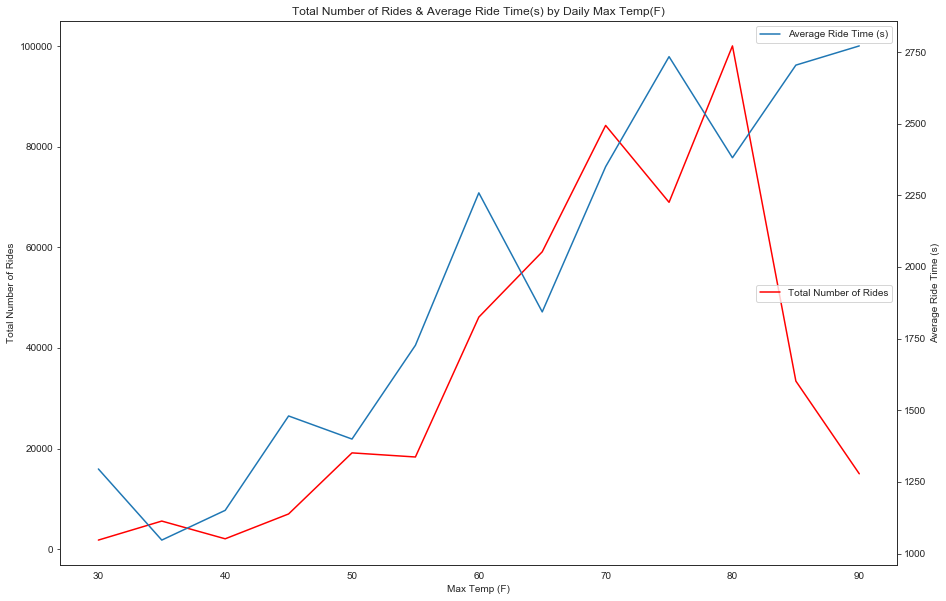

In [38]:
sns.set_style("white")

fig, ax1 = plt.subplots(figsize=(15, 10))

line1 = sns.lineplot(x = 'Max Temp (F)', y = 'Total Number of Rides', data = agg_by_max_temp, ax = ax1, color = 'r')

ax2 = ax1.twinx()

line2 = sns.lineplot(x = 'Max Temp (F)', y = 'Average Ride Time (s)', data = agg_by_max_temp, ax = ax2)

plt.title("Total Number of Rides & Average Ride Time(s) by Daily Max Temp(F)")
line2.legend(['Average Ride Time (s)'])
line1.legend(['Total Number of Rides'], loc = 5)

plt.show()

# __Analysis 5: Break down rides by day of week__

### After seeing such strange riding behavior, we went to one more possible influence on riding behavior.... day of the week
* We create a *day_of_week* dataframe using a copy of our *trips_weather_df* dataframe
* We once again create a datetime field using the "Start date" column, which we assign back to itself
* We then create a "Day of Week" column using datetime and getting the week day from the "Start date"

In [39]:
day_of_week = trips_weather_df
day_of_week['Start date'] = pd.to_datetime(day_of_week['Start date'])
day_of_week['Day of Week'] = day_of_week['Start date'].dt.weekday_name
day_of_week.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds),DATE,TMAX,TMIN,PRCP,max_temp_range,Day of Week
0,2017-11-05,Hennepin Ave & S Washington Ave,30184,2017-11-05,Logan Park,30104,Member,1048,2017-11-05,41,33,0.1,"[40, 45)",Sunday


### A lot to unpack in this step, so we'll go slowly
* First, we aggregate by the day of the week and create an *agg_day_of_week* dataframe, and get our observations - counts and average ride time
* We rename our columns as we have done above for consistency and readability
* We then to reorganize our data so it follows the normal format of a week, going from Monday - Sunday
    - If we don't do this, then graphing the data is all over the place
    - If Monday is our first row in the dataset, it's a success!

In [40]:
agg_day_of_week = day_of_week.groupby('Day of Week', as_index = False).agg({'Start station number': 'count', 'Total duration (Seconds)': 'mean'})
agg_day_of_week.rename({'Start station number': 'Total Number of Rides', 
                        'Total duration (Seconds)': 'Average Ride Time(s)'}, axis = 'columns', inplace = True)

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

agg_day_of_week['Day of Week'] = pd.Categorical(agg_day_of_week['Day of Week'], categories = cats, ordered = True)
agg_day_of_week.sort_values(by = 'Day of Week', inplace = True)
agg_day_of_week.head(1)

,Day of Week,Average Ride Time(s),Total Number of Rides
1,Monday,2006.683292,59408


### Seaborn, again, makes this visual look really great
### On the left, we created a barplot for the total number of rides for each day of the week, and the data seems to validate our assumption - weekends see an increase in usage & riders
### On the right, we observe that the average ride times are **heavily** influenced by weekends.... our riders spend much more time riding around on weekends than during the week!

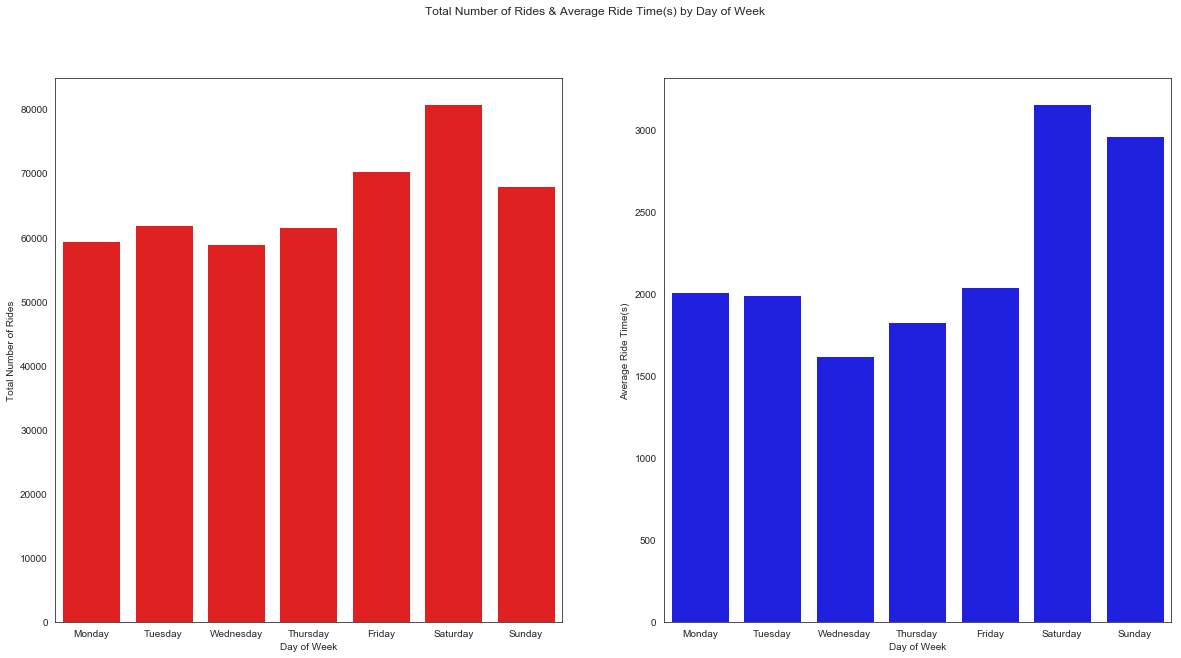

In [41]:
sns.set_style("white")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.barplot(x = 'Day of Week', y = 'Total Number of Rides', data = agg_day_of_week, ax = ax1, color = 'r')

sns.barplot(x = 'Day of Week', y = 'Average Ride Time(s)', data = agg_day_of_week, ax = ax2, color = 'b')

fig.suptitle("Total Number of Rides & Average Ride Time(s) by Day of Week")

plt.show()